In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
import collections
import gc
import time
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, Flatten
from tensorflow.keras.models import Sequential, Model, load_model

<h2> 1000-State Random Walk </h2><br/>
<b>Problem Credit:</b> Sutton & Barto, 2018 <br/><br/>
Consider a 1000-state version of the random walk where all states are numbered from 1 to 1000, left to right, and all episodes begin in state 500. The agent can transition from its current state to either one of the 100 immediate left states, or 100 immediate right states, with equal probability. If the current state is near an edge, then there may be fewer than 100 neighbors in which case all  probability for those missing neighbors goes into the probability of terminating on that side (thus, state 1 has a 0.5 probability of left termination and state 950 has a 0.25 probability of right termination). Left termination yields a -1 reward, and a right termination yields a +1 reward.

<b> STEP 1: Dynamic Programming Ground Truth </b><br/><br/>
We first use dynamic programming to establish ground-truth in the problem, before proceeding to evaluate function approximation approaches in their error. 

In [2]:
start = time.time()
error = 1e-3
v0 = np.zeros(1000, dtype=np.float64)
v1 = v0.copy()
actions = np.arange(200, dtype=np.int64)
actions[actions<100]-=100
actions[actions>=100]-=99
breaker = False
while (not breaker):
    for i in range(1000):
        totalvalue = 0
        for j in actions:
            newstate = (i+1)+j
            if (newstate<1) or (newstate>1000):
                totalvalue+=1 if newstate>1000 else -1
            else:
                totalvalue+=v0[newstate-1]
        v1[i] = totalvalue/200
    if np.max(np.abs(v0-v1))<error:
        breaker=True
    else:
        np.copyto(v0,v1)
print("Ground Truth Established in "+str(time.time()-start)+" seconds")

Ground Truth Established in 14.434396743774414 seconds


<b> STEP 2: Semi-Gradient TD with Artificial Neural Network </b><br/><br/>
We use semi-gradient TD with neural networks, and tilings to learn the value function of the uniform random policy, and compare it to the dynamic programming ground-truth. Using stochastic gradient descent, state-value prediction updates with TD are:

$$\mathbf{w_{t+1}} = \mathbf{w_{t}} + \alpha \delta_t \nabla \hat{v}(S_t,\mathbf{w_{t}})$$

The direction of weight update at each time step is $g_t = \delta_t \nabla \hat{v}(S_t,\mathbf{w_t})$ using a fixed step-size $\alpha$. $\delta_t = R_{t+1} + \gamma \hat{v}(S_{t+1},\mathbf{w_{t}}) - \hat{v}(S_t,\mathbf{w_t})$ is the TD-error. $\nabla \hat{v}(S_t,\mathbf{w_{t}})$ is the gradient of the value function with respect to the weights. To leverage existing Tensorflow architecture, we can use a bootstrapped design with mean-squared error loss metric on a dense ANN, with the truth label being $R_{t+1} + \gamma \hat{v}(S_{t+1},\mathbf{w_{t}})$ and the predicted label is, by design, $\hat{v}(S_t,\mathbf{w_t})$.

In [3]:
def get_move(curstate):
    action = np.random.choice(200)
    action -=100 if action<100 else 99
    newstate = curstate + action
    return (0,-1) if newstate<1 else (1001,1) if newstate>1000 else (newstate,0)

In [4]:
tf.keras.backend.clear_session()
inp = Input((1,))
data = Embedding(1000, 1000, weights=[np.eye(1000)], trainable=False)(inp)
data = Flatten()(data)
data = Dense(100, activation="relu", kernel_initializer="glorot_uniform", 
             bias_initializer="glorot_normal")(data)
data = Dense(1, activation=None, kernel_initializer="glorot_uniform", 
             bias_initializer="glorot_normal")(data)
valmodel = Model(inputs=inp, outputs=data)
valmodel.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.MeanSquaredError())
valmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 1, 1000)           1000000   
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               100100    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,100,201
Trainable params: 100,201
Non-trainable params: 1,000,000
_________________________________________________________________


In [5]:
iterations = 10000
start = time.time()
traininglst = collections.deque()
for i in range(iterations):
    state = 500
    while ((state!=0) and (state!=1001)):
        newstate, reward = get_move(state)
        traininglst.append((state, newstate, reward))
        state = newstate
traininglst = np.array(traininglst)
startindex = 0
rmse = collections.deque()
while startindex<traininglst.shape[0]:
    data = traininglst[startindex:startindex+32,]
    mask = (data[:,1]==0)|(data[:,1]==1001)
    data[:,1][mask] = 1
    y = valmodel.predict(data[:,1]-1)[:,0]
    y[mask] = 0
    valmodel.fit(data[:,0]-1, data[:,2]+y, verbose=False, batch_size=32)
    startindex+=32
    rmse.append((np.sqrt(np.mean((valmodel.predict(np.arange(1000))[:,0]-v1)**2)), startindex))
print("Process Elapsed in "+str(time.time()-start)+" seconds")

Process Elapsed in 1890.6263699531555 seconds


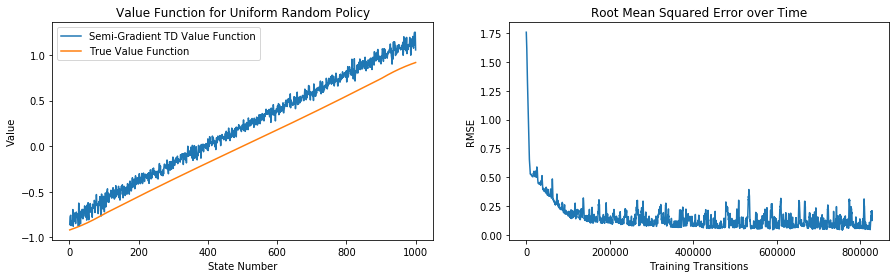

In [11]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
pd.Series(valmodel.predict(np.arange(1000))[:,0], index=np.arange(1000)+1).plot(
    label="Semi-Gradient TD Value Function")
pd.Series(v1, index=np.arange(1000)+1).plot(label="True Value Function")
plt.title("Value Function for Uniform Random Policy")
plt.xlabel("State Number")
plt.ylabel("Value")
plt.legend(loc="best")
plt.subplot(1,2,2)
plt.plot(np.array(rmse)[:,1], np.array(rmse)[:,0])
plt.xlabel("Training Transitions")
plt.ylabel("RMSE")
plt.title("Root Mean Squared Error over Time")
plt.show()

<b> STEP 3: Monte-Carlo Gradient Descent with Tiling </b><br/><br/>
We use 10 separate tilings, each of which divide the overall input space into maximum chunks of 200, offset from state 1. Hence, each tiling has 6 sections (accounting for offset), giving a 60-length feature vector for each state. We use linear methods to estimate the weight vector, using Monte Carlo updates.

In [30]:
def make_tilings(numtiles, division):
    tiles = np.full((numtiles, division+1), np.int(1000/division), dtype=np.int64)
    tiles[:,0] = np.random.choice(np.int(1000/division), numtiles, replace=False)+1
    tiles = np.cumsum(tiles, axis=1)
    tiles[:,-1] = 1000
    return tiles
def get_feature(tiles, curstate):
    allintervals = np.where(curstate<=tiles)
    uniq = np.unique(allintervals[0], return_index=True)[1]
    row, col = allintervals[0][uniq], allintervals[1][uniq]
    rep = np.zeros(tiles.shape[0]*tiles.shape[1])
    rep[row*tiles.shape[1]+col] = 1
    return rep

In [31]:
def mc_tile_experiment(numtiles, division, truth, iterations=10000, alpha=2e-4):
    start = time.time()
    tiles = make_tilings(numtiles, division)
    weight = np.zeros(numtiles*(division+1), dtype=np.float64)
    rmse = np.zeros(iterations, dtype=np.float64)
    values = np.zeros(1000, dtype=np.float64)
    for i in range(iterations):
        state = 500
        episodelst = collections.deque()
        while ((state!=0) and (state!=1001)):
            newstate, reward = get_move(state)
            episodelst.append(state)
            state = newstate
        for state in episodelst:
            feat = get_feature(tiles, state)
            weight+=alpha*(reward-np.sum(weight*feat))*feat
        for state in range(1000):
            values[state] = np.sum(get_feature(tiles, state+1)*weight)
        rmse[i] = np.sqrt(np.mean((values-truth)**2))
    print("Process Elapsed in "+str(time.time()-start)+" seconds")
    return weight, values, rmse

In [32]:
wh1, val1, rmse1 = mc_tile_experiment(10,5,v1)
wh2, val2, rmse2 = mc_tile_experiment(20,3,v1)

Process Elapsed in 273.69329810142517 seconds
Process Elapsed in 278.8486559391022 seconds


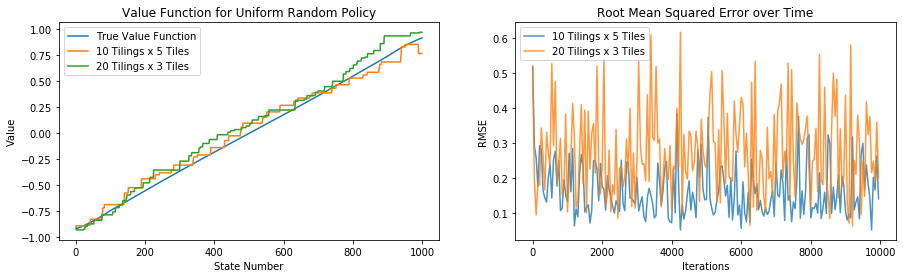

In [37]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
pd.Series(v1, index=np.arange(1000)+1).plot(label="True Value Function")
pd.Series(val1, index=np.arange(1000)+1).plot(label="10 Tilings x 5 Tiles")
pd.Series(val2, index=np.arange(1000)+1).plot(label="20 Tilings x 3 Tiles")
plt.xlabel("State Number")
plt.ylabel("Value")
plt.title("Value Function for Uniform Random Policy")
plt.legend(loc="best")
plt.subplot(1,2,2)
pd.Series(rmse1)[::50].plot(label="10 Tilings x 5 Tiles", alpha=0.8)
pd.Series(rmse2)[::50].plot(label="20 Tilings x 3 Tiles", alpha=0.8)
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("Root Mean Squared Error over Time")
plt.legend(loc="best")
plt.show()

<h2> Mountain Car Continuous State Space </h2><br/>
<b>Problem Credit:</b> Alberta Machine Learning Institute <br/><br/>
We consider the continuous control task of driving a low-power car up a steep mountain, shown in the figure. Given a low power engine, the car cannot directly accelerate up the slope, but must rather climb the left slope to gain enough inertia. The reward in this problem is -1 on all time steps until the car moves past its goal position at the top of the mountain, which ends the episode. There are three possible actions: full throttle forward (+1), full throttle reverse (-1), and zero throttle (0). To simplify the physics, the car's movement is determined only by position $x_t$ and velocity $\dot{x}_t$. These are updated as:<br/>
$x_{t+1} = bound[x_t + \dot{x}_{t+1}]$<br/>
$\dot{x}_{t+1} = bound[\dot{x}_t + 0.001A_t - 0.0025cos(3x_t)]$

where the bound enforces $-1.2 \le x_{t+1} \le 0.5$ and $-0.07 \le \dot{x}_{t+1} \le 0.07$. In addition, when $x_{t+1}$ reached the left bound, $\dot{x}_{t+1}$ was reset to zero. When it reached the right bound, the goal was reached and episode terminated. Each episode started from a random position $x_t \in [-0.6, -0.4)$ and zero velocity.
<img src="Mountain-Car.png" style="height:200px">

In [2]:
def get_pos_vel(xt, dotxt, At):
    dotxt1 = max(min(dotxt + 0.001*At - 0.0025*np.cos(3*xt), 0.07), -0.07)
    xt1 = max(min(xt+dotxt1, 0.5), -1.2)
    return (xt1, 0) if xt1==-1.2 else (xt1, dotxt1)

<b> STEP 1: Linear Function Approximation with 2-D Tiling </b><br/><br/>
We use 8 tilings with 8 tiles each to cover position, and similarly for velocity. Thus, 64-length vector represents position and 64-length vector for velocity, giving a 128-length state vector. In addition, we stack the three actions together, to get a 384-length state-action representation. Since all values will be negative (as all rewards are negative), we can initialize all weights to 0 to encourage exploration.

In [40]:
def make_tilings(numtiles, division, leftlim, rightlim):
    tiles = np.full((numtiles, division+1), (rightlim-leftlim)/division, dtype=np.float64)
    tiles[:,0] = np.random.uniform(low=leftlim, high=leftlim+(rightlim-leftlim)/division, size=numtiles)
    tiles = np.cumsum(tiles, axis=1)
    tiles[:,-1] = rightlim
    return tiles
def get_feature(postiles, veltiles, xt, dotxt, At):
    rep = np.zeros(3*(postiles.shape[0]*postiles.shape[1]+veltiles.shape[0]*veltiles.shape[1]))
    offset = 0
    action = 0 if At==-1 else np.int(rep.shape[0]/3) if At==0 else np.int(2*rep.shape[0]/3)
    for value, tiles in [(xt, postiles), (dotxt, veltiles)]:
        allintervals = np.where(value<=tiles)
        uniq = np.unique(allintervals[0], return_index=True)[1]
        row, col = allintervals[0][uniq], allintervals[1][uniq]
        rep[action+offset+row*tiles.shape[1]+col] = 1
        offset+=tiles.shape[0]*tiles.shape[1]
    return rep

In [73]:
def get_epsilon_greedy_action(postiles, veltiles, xt, dotxt, weight, epsilon):
    stateact = collections.deque()
    for At in [-1,0,1]:
        val = get_feature(postiles, veltiles, xt, dotxt, At)
        stateact.append(np.sum(val*weight))
    maxacts = np.where(stateact==np.max(stateact))[0]-1
    prob = np.random.uniform()
    if prob<=1-epsilon:
        return np.random.choice(maxacts)
    return np.random.choice([-1,0,1])

In [71]:
get_epsilon_greedy_action(postiles, veltiles, -0.5, 0, weight, 0.2)

[-1]


-1

In [81]:
numtiles, division, epsilon, alpha = 8, 7, 0.2, 0.05/8
weight = np.zeros((numtiles*(division+1))*6)

In [84]:
def one_episode_sarsa(numtiles, division, epsilon, alpha, weight):
    postiles = make_tilings(numtiles, division, -1.2, 0.5) 
    veltiles = make_tilings(numtiles, division, -0.07, 0.07)
    xt, dotxt = np.random.uniform(low=-0.6, high=-0.4), 0
    At = get_epsilon_greedy_action(postiles, veltiles, xt, dotxt, weight, epsilon)
    xt1, dotxt1 = get_pos_vel(xt, dotxt, At)
    while (xt1<0.5):
        At1 = get_epsilon_greedy_action(postiles, veltiles, xt1, dotxt1, weight, epsilon)
        vect = get_feature(postiles, veltiles, xt, dotxt, At)
        vect1 = get_feature(postiles, veltiles, xt1, dotxt1, At1)
        weight+=alpha*(-1+np.sum(vect1*weight)-np.sum(vect*weight))*vect
        xt, dotxt, At = xt1, dotxt1, At1
        xt1, dotxt1 = get_pos_vel(xt, dotxt, At)
    vect = get_feature(postiles, veltiles, xt, dotxt, At)
    weight+=alpha*(-1-np.sum(vect*weight))*vect

ONE MOVE
-0.4092217924644569
0
1
-0.1
ONE MOVE
-0.409062885389243
0.0001589070752138987
1
-0.19
ONE MOVE
-0.40874619347119323
0.00031669191804980406
-1
-0.29000000000000004
ONE MOVE
-0.41027395267855177
-0.0015277592073585445
-1
-0.38
ONE MOVE
-0.4136353694417498
-0.0033614167631980047
0
-0.4978125
ONE MOVE
-0.41780663412611313
-0.004171264684363368
1
-0.591044921875
ONE MOVE
-0.42175808653548563
-0.003951452409372478
0
-0.6910449218749999
ONE MOVE
-0.42646151671100885
-0.0047034301755232155
0
-0.7971357421875
ONE MOVE
-0.43188320880160136
-0.005421692090592527
1
-0.8878125
ONE MOVE
-0.4369841211976578
-0.005100912396056407
-1
-1.00620341796875
ONE MOVE
-0.4437273579846273
-0.00674323678696954
1
-1.0996515917968752
ONE MOVE
-0.45006391456631445
-0.0063365565816871266
-1
-1.1996515917968753
ONE MOVE
-0.4579475201336577
-0.007883605567343256
-1
-1.2855808166503908
ONE MOVE
-0.46732033295571995
-0.00937281282206226
0
-1.3835564208984374
ONE MOVE
-0.47711323165660474
-0.009792898700884806


-17.949729915635814
ONE MOVE
-0.7191258340516
-0.0010705242965322408
1
-18.040738596459704
ONE MOVE
-0.7178125660068637
0.0013132680447362913
1
-18.153940919423587
ONE MOVE
-0.7141237193849761
0.0036888466218876113
-1
-18.253940919423584
ONE MOVE
-0.7100824796854016
0.004041239699574466
-1
-18.34896904202817
ONE MOVE
-0.7057144373108647
0.004368042374536882
1
-18.426091397029733
ONE MOVE
-0.6990474712773105
0.00666696603355426
-1
-18.514103968743505
ONE MOVE
-0.6921245618648156
0.006922909412494836
0
-18.614103968743507
ONE MOVE
-0.6839908708289636
0.008133691035852049
0
-18.714103968743505
ONE MOVE
-0.6747001242549427
0.009290746574020865
0
-18.805239043189793
ONE MOVE
-0.664314531998118
0.010385592256824729
1
-18.848525443056833
ONE MOVE
-0.6519046393431249
0.01240989265499306
1
-18.94852544305683
ONE MOVE
-0.6375560397902378
0.014348599552887094
1
-19.053525605859633
ONE MOVE
-0.6213693123671248
0.01618672742311303
0
-19.142106445633143
ONE MOVE
-0.6044597749899737
0.016909537377151

-0.21389668708764603
0.006951971075704239
-1
-35.51878368004756
ONE MOVE
-0.20994742930186003
0.003949257785785991
0
-35.63579820979754
ONE MOVE
-0.208018472549865
0.0019289567519950365
-1
-35.73532139251691
ONE MOVE
-0.2091183043733579
-0.0010998318234929087
1
-35.8353213925169
ONE MOVE
-0.21124209374407643
-0.002123789370718538
1
-35.93477959430142
ONE MOVE
-0.2143804495761551
-0.0031383558320786757
0
-36.03138702966511
ONE MOVE
-0.21951934491889205
-0.005138895342736961
0
-36.1271148005288
ONE MOVE
-0.22663542901933068
-0.007116084100438617
-1
-36.21971050547991
ONE MOVE
-0.23669559222322095
-0.01006016320389029
1
-36.3546425689181
ONE MOVE
-0.24765151870003987
-0.010955926476818919
-1
-36.48417904175804
ONE MOVE
-0.2614486279692926
-0.013797109269252702
0
-36.52914967522256
ONE MOVE
-0.27701536339735816
-0.015566735428065602
0
-36.629149675222564
ONE MOVE
-0.29426735744588
-0.017251994048521836
0
-36.65892215945354
ONE MOVE
-0.3131068239434101
-0.018839466497530086
-1
-36.807709271

ONE MOVE
-0.6803769726879014
-0.037459841906513774
1
-53.80605365736268
ONE MOVE
-0.7157038531669461
-0.0353268804790446
0
-53.84934022154458
ONE MOVE
-0.7496683885131021
-0.03396453534615604
0
-53.968124730333265
ONE MOVE
-0.7820644257143309
-0.032396037201228786
0
-54.02796198017923
ONE MOVE
-0.8127104638908338
-0.030646038176502965
1
-54.1819366595701
ONE MOVE
-0.8404499825571827
-0.027739518666348894
1
-54.222199343486174
ONE MOVE
-0.8651551576934803
-0.024705175136297594
0
-54.323112467025204
ONE MOVE
-0.8877239768375227
-0.02256881914404246
0
-54.41856026623855
ONE MOVE
-0.9080734882477207
-0.020349511410198015
1
-54.56843749346448
ONE MOVE
-0.9251376063980961
-0.017064118150375306
1
-54.703576710106496
ONE MOVE
-0.938867469623339
-0.013729863225242946
-1
-54.8035767101065
ONE MOVE
-0.9512281982452909
-0.012360728621951925
-1
-54.88473209389023
ONE MOVE
-0.962191826933341
-0.010963628688050092
0
-54.98746960813133
ONE MOVE
-0.9707363082119198
-0.008544481278578795
0
-55.086517109

-72.01889714047688
ONE MOVE
-1.1789331358404163
-0.017638021540077146
-1
-72.10730117707925
ONE MOVE
-1.1952638649204184
-0.016330729080002052
0
-72.27603007492326
ONE MOVE
-1.2
0
0
-72.35068415188167
ONE MOVE
-1.1977581039591645
0.002241896040835368
1
-72.45068415188167
ONE MOVE
-1.192266922003125
0.00549118195603954
1
-72.52533762986255
ONE MOVE
-1.1835087842422778
0.008758137760847242
1
-72.59251744372173
ONE MOVE
-1.1714567831343694
0.012052001107908415
1
-72.66969944400728
ONE MOVE
-1.1560764837952135
0.015380299339155816
-1
-72.74992451775249
ONE MOVE
-1.139328367422801
0.01674811637241263
-1
-72.8461928997157
ONE MOVE
-1.1211751356765196
0.01815323174628141
0
-72.96147387734388
ONE MOVE
-1.1005832193232654
0.02059191635325427
0
-73.03479047355324
ONE MOVE
-1.077523297326132
0.02305992199713356
-1
-73.14750154774767
ONE MOVE
-1.052973714267267
0.024549583058864934
-1
-73.23238389175302
ONE MOVE
-1.0269245065446828
0.026049207722584167
1
-73.30939820545883
ONE MOVE
-0.997379921105

-90.72691218897052
ONE MOVE
-1.1013453375800806
0.021828104145502923
0
-90.82982942013899
ONE MOVE
-1.07705014577135
0.024295191808730597
0
-90.89841162412567
ONE MOVE
-1.050264973009154
0.026785172762195875
0
-90.99336148696025
ONE MOVE
-1.0209799060983227
0.02928506691083137
1
-91.03022377831478
ONE MOVE
-0.9882025680571314
0.03277733804119136
1
-91.16229932759492
ONE MOVE
-0.9519642825075328
0.03623828554959852
-1
-91.23769842389066
ONE MOVE
-0.9143273353029434
0.03763694720458945
-1
-91.33110918166072
ONE MOVE
-0.8753863852379941
0.038940950064949374
0
-91.48336767371379
ONE MOVE
-0.8342702373537421
0.041116147884252004
0
-91.56902717634334
ONE MOVE
-0.7911470330153659
0.043123204338376166
1
-91.66902717634335
ONE MOVE
-0.7452258381508985
0.045921194864467385
1
-91.77732201844806
ONE MOVE
-0.6967622292040645
0.048463608946833964
0
-91.87732201844807
ONE MOVE
-0.6470575257605367
0.04970470344352786
0
-91.98655805669222
ONE MOVE
-0.5964479068295631
0.05060961893097363
1
-92.029405573

-1.1337113622449753
0.0011891952194113316
-1
-108.65961424011414
ONE MOVE
-1.1311058976127075
0.0026054646322677052
1
-108.75085840660492
ONE MOVE
-1.1250792224835469
0.006026675129160582
1
-108.83587673915613
ONE MOVE
-1.115620474985656
0.009458747497890954
0
-108.929016126529
ONE MOVE
-1.103714211897431
0.011906263088224848
-1
-109.02377091816108
ONE MOVE
-1.0903437968037222
0.013370415093708893
-1
-109.13803431632289
ONE MOVE
-1.0754942954690063
0.01484950133471592
-1
-109.2494439626357
ONE MOVE
-1.0591537966655928
0.016340498803413595
-1
-109.3199436154733
ONE MOVE
-1.0413149058975788
0.017838890768014065
0
-109.4199436154733
ONE MOVE
-1.0209764044315124
0.020338501466066434
0
-109.47495981430464
ONE MOVE
-0.9981456338987171
0.022830770532795204
0
-109.57991798458511
ONE MOVE
-0.9728418830733296
0.02530375082538744
1
-109.63912923225348
ONE MOVE
-0.9441000733747459
0.028741809698583733
1
-109.6824190049434
ONE MOVE
-0.9119768907242701
0.032123182650475764
0
-109.78241900494339
ONE 

-126.17621215831906
ONE MOVE
-1.1354829780802056
0.017036921067315133
-1
-126.27621215831905
ONE MOVE
-1.1170332316820313
0.018449746398174253
-1
-126.39209120743365
ONE MOVE
-1.0971381513889222
0.01989508029310902
1
-126.48085543789205
ONE MOVE
-1.0737710768657491
0.02336707452317316
1
-126.55527322494544
ONE MOVE
-1.0469119423490971
0.026859134516651957
1
-126.65527322494543
ONE MOVE
-1.0165528087501348
0.03035913359896236
1
-126.69078366184324
ONE MOVE
-0.9827042325898547
0.03384857616028006
0
-126.79144706660522
ONE MOVE
-0.9464023037551799
0.03630192883467488
0
-126.86029379112402
ONE MOVE
-0.9077138030806177
0.03868850067456219
0
-126.96985574859569
ONE MOVE
-0.8667410039903586
0.040972799090259034
0
-127.0361057902149
ONE MOVE
-0.823625695662508
0.04311530832785058
0
-127.16759877093621
ONE MOVE
-0.7785519445636232
0.04507375109888481
0
-127.2083419189445
ONE MOVE
-0.7317471043585324
0.04680484020509079
0
-127.33946570178647
ONE MOVE
-0.6834806464354675
0.04826645792306492
1
-12

-0.8712285384175324
0.040030030625923536
1
-145.3768688763326
ONE MOVE
-0.828038849686891
0.043189688730641426
-1
-145.50857429363919
ONE MOVE
-0.7838703180648564
0.04416853162203463
-1
-145.61480558384852
ONE MOVE
-0.7389421406542496
0.044928177410606784
1
-145.67564480597719
ONE MOVE
-0.6915089100731118
0.04743323058113781
1
-145.77564480597718
ONE MOVE
-0.6418689396615037
0.04963997041160803
1
-145.80692532955473
ONE MOVE
-0.59036043758074
0.05150850208076376
-1
-145.9128048613161
ONE MOVE
-0.5393545639301619
0.05100587365057812
0
-146.0116660621722
ONE MOVE
-0.4882305658642322
0.05112399806592973
0
-146.1500153761273
ONE MOVE
-0.43737133192377375
0.05085923394045845
1
-146.20908282799573
ONE MOVE
-0.38615161535078807
0.051219716572985685
1
-146.26287187606715
ONE MOVE
-0.3349337879129866
0.05121782743780145
-1
-146.4102870863774
ONE MOVE
-0.2860566001884592
0.04887718772452744
-1
-146.4860485914814
ONE MOVE
-0.23981397090820206
0.04624262928025712
1
-146.62604715982792
ONE MOVE
-0.

-164.0355560483431
ONE MOVE
-0.44872951020493584
0.054957386906979995
-1
-164.13555604834312
ONE MOVE
-0.3953289333654798
0.05340057683945602
-1
-164.24078559725626
ONE MOVE
-0.34386681302497024
0.05146212034050958
0
-164.40455206810367
ONE MOVE
-0.2936883080130227
0.05017850501194756
-1
-164.50039288335648
ONE MOVE
-0.2461006280128475
0.04758768000017523
0
-164.6266379314905
ONE MOVE
-0.20036197929397662
0.04573864871887088
1
-164.72663793149053
ONE MOVE
-0.1556851354794446
0.04467684381453201
1
-164.80862977316355
ONE MOVE
-0.11224053663261545
0.04344459884682915
-1
-164.9544029279686
ONE MOVE
-0.07215554503095525
0.040084991601660194
-1
-165.0544029279686
ONE MOVE
-0.035512209531161965
0.03664333549979329
-1
-165.17274630449356
ONE MOVE
-0.0023546998788889772
0.03315750965227299
0
-165.30950353159005
ONE MOVE
0.028302872150004214
0.03065757202889319
1
-165.40950353159005
ONE MOVE
0.05746945060741361
0.029166578457409394
1
-165.50383706051298
ONE MOVE
0.08517309291879244
0.0277036423

-0.6595975809264334
0.049804534127924883
1
-182.65058746756063
ONE MOVE
-0.6078011192972218
0.05179646162921158
1
-182.7125564776906
ONE MOVE
-0.5543798349168781
0.05342128438034367
0
-182.81358179812403
ONE MOVE
-0.5007280205495014
0.05365181436737677
-1
-182.9151348797174
ONE MOVE
-0.4482476022924804
0.05248041825702097
-1
-183.123685098181
ONE MOVE
-0.39732751704329855
0.05092008524918183
0
-183.22971872790865
ONE MOVE
-0.3473319783044049
0.04999553873889366
1
-183.29994684423306
ONE MOVE
-0.2975976844338624
0.049734293870542436
1
-183.38374866987093
ONE MOVE
-0.24843148849211857
0.04916619594174384
-1
-183.4503720970585
ONE MOVE
-0.20210251312843075
0.04632897536368784
-1
-183.6230742909716
ONE MOVE
-0.15882793205456708
0.043274581073863685
-1
-183.76186501158304
ONE MOVE
-0.11877488384541035
0.04005304820915672
0
-183.85650648241972
ONE MOVE
-0.08106479871174838
0.03771008513366198
0
-183.97443306279186
ONE MOVE
-0.04578114783795919
0.03528365087378919
0
-184.0641970517408
ONE MOV

-1.1865022469892634
0.005761411546830676
-1
-200.0564782108337
ONE MOVE
-1.179455991677601
0.007046255311662343
1
-200.16970343991852
ONE MOVE
-1.1691039564860422
0.0103520351915589
-1
-200.2290761375579
ONE MOVE
-1.1574172543045027
0.011686702181539535
1
-200.30573117418956
ONE MOVE
-1.1423659807272875
0.015051273577215255
1
-200.3830824245407
ONE MOVE
-1.1239159084888173
0.0184500722384702
1
-200.4761215360457
ONE MOVE
-1.1020317586743569
0.02188414981446042
1
-200.56617849864733
ONE MOVE
-1.076681359038008
0.025350399636348973
-1
-200.62728187714936
ONE MOVE
-1.0498407325952293
0.02684062644277865
-1
-200.7229064026409
ONE MOVE
-1.0215001847491276
0.028340547846101537
1
-200.79551839796522
ONE MOVE
-0.9896670622141552
0.031833122534972336
1
-200.83261673154004
ONE MOVE
-0.9543710821104574
0.03529598010369781
-1
-200.91473982017294
ONE MOVE
-0.917671415628097
0.03669966648236045
1
-201.01473982017296
ONE MOVE
-0.8776581276497617
0.040013287978335296
1
-201.0673000474112
ONE MOVE
-0.8

In [83]:
weight

array([-8.21600066e-01, -6.28384771e-01, -7.10116444e-01, -7.40180866e-01,
       -6.03207880e-01, -7.48443625e-01, -1.79969016e-01,  0.00000000e+00,
       -7.70957405e-01, -6.30139703e-01, -7.09757030e-01, -7.38894090e-01,
       -6.26571121e-01, -7.50350916e-01, -2.05232404e-01,  0.00000000e+00,
       -5.81338777e-01, -5.96042218e-01, -7.25518107e-01, -7.63268446e-01,
       -6.15428320e-01, -6.86500448e-01, -4.33350014e-01, -3.04563371e-02,
       -4.51422526e-01, -6.25453228e-01, -6.80830702e-01, -7.47895452e-01,
       -6.30052048e-01, -6.85792385e-01, -5.41518833e-01, -6.89374948e-02,
       -4.97245036e-01, -6.03909331e-01, -6.90310083e-01, -7.37914915e-01,
       -6.47872014e-01, -6.82076263e-01, -5.12094093e-01, -6.04809333e-02,
       -5.21011829e-01, -6.05309529e-01, -6.90154454e-01, -7.40859513e-01,
       -6.39653773e-01, -6.79817206e-01, -5.00664272e-01, -5.44320920e-02,
       -8.43029714e-01, -6.10946954e-01, -7.16684729e-01, -7.44497930e-01,
       -6.18632253e-01, -